### KDD 2022 Hands-on Tutorial on "Gradual AutoML using Lale"

# 3. Customizing Algorithm Choices and Hyperparameters

This notebook describes how you can create custom pipeline search spaces with Lale using operators and combinators.
Beyond customizing the shape of the pipeline and the algorithm choices in the pipeline, this notebook also highlights how you can customize the search spaces for operator hyperparameters.
Given a pipeline search space, you can run AutoML on this search space to get the best pipeline configuration.
After AutoML, we present how you can modify and refine the pipeline and how you can run AutoML on just a part of the pipeline.

This notebook has the following sections:

- [3.1 Combinators](#3.1-Combinators)
- [3.2 Dataset](#3.2-Dataset)
- [3.3 Data Cleaning](#3.3-Data-Cleaning)
- [3.4 Custom Data-prep](#3.4-Custom-Data-prep)
- [3.5 Final Classifiers](#3.5-Final-Classifiers)
- [3.6 AutoML with Custom Pipeline](#3.6-AutoML-with-Custom-Pipeline)
- [3.7 Pipeline Refinement](#3.7-Pipeline-Refinement)

## 3.1 Combinators

Lale provides the following combinators to define pipelines and search spaces:

| Symbol | Name | Description | `sklearn` feature | Example |
|:------:|:----:|:-----------:|:-----------------:|:-------:|
| `>>`   | Pipe | Feed to next | `make_pipeline` | `PCA >> LogisticRegression` |
| `&`    | And  | Run both | `make_union` includes `ConcatFeatures` | `(PCA & SelectKBest) >> ConcatFeatures` |
| `\|`    | Or   | Choose one | missing | `LogisticRegression \| MLPClassifier` |

## 3.2 Dataset

This demonstration uses the [credit-g](https://www.openml.org/d/31) dataset from OpenML.
The dataset has both categorical features, represented as strings, and
numeric features.
For illustration purposes, we also add some missing values, represented as `NaN`.

In [1]:
import lale.datasets.openml
import lale.helpers
(train_X, train_y), (test_X, test_y) = \
    lale.datasets.openml.fetch('credit-g', 'classification', preprocess=False)
print(f'train_X.shape {train_X.shape}, train_y.shape {train_y.shape}')

train_X.shape (670, 20), train_y.shape (670,)


In [2]:
train_X = lale.helpers.add_missing_values(train_X, seed=42)
print(f'train_X.shape {train_X.shape} train_y.shape {train_y.shape}')

train_X.shape (670, 20) train_y.shape (670,)


Printing the last few samples of the training data reveals
`credit_amount=NaN` for sample number 763.

In [3]:
import pandas as pd
pd.options.display.max_columns = None
NROWS = 8
df = pd.concat([train_y.tail(NROWS), train_X.tail(NROWS)], axis=1)
display(df.style.highlight_null('yellow'))

,class,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
359,bad,<0,30.000000,existing paid,furniture/equipment,2406.000000,<100,4<=X<7,4.000000,female div/dep/mar,none,4.000000,real estate,23.000000,none,rent,1.000000,skilled,1.000000,none,yes
707,bad,0<=X<200,12.000000,no credits/all paid,furniture/equipment,2969.000000,<100,<1,4.000000,female div/dep/mar,none,3.000000,life insurance,25.000000,none,rent,2.000000,skilled,1.000000,none,yes
763,bad,no checking,21.000000,critical/other existing credit,new car,nan,no known savings,>=7,4.000000,male single,none,4.000000,no known property,30.000000,none,for free,1.000000,high qualif/self emp/mgmt,1.000000,yes,yes
835,bad,<0,12.000000,no credits/all paid,new car,1082.000000,<100,1<=X<4,4.000000,male single,none,4.000000,car,48.000000,bank,own,2.000000,skilled,1.000000,none,yes
192,bad,0<=X<200,27.000000,existing paid,business,3915.000000,<100,1<=X<4,4.000000,male single,none,2.000000,car,36.000000,none,own,1.000000,skilled,2.000000,yes,yes
629,good,no checking,9.000000,existing paid,education,3832.000000,no known savings,>=7,1.000000,male single,none,4.000000,real estate,64.000000,none,own,1.000000,unskilled resident,1.000000,none,yes
559,bad,0<=X<200,18.000000,critical/other existing credit,furniture/equipment,1928.000000,<100,<1,2.000000,male single,none,2.000000,real estate,31.000000,none,own,2.000000,unskilled resident,1.000000,none,yes
684,good,0<=X<200,36.000000,delayed previously,business,9857.000000,100<=X<500,4<=X<7,1.000000,male single,none,3.000000,life insurance,31.000000,none,own,2.000000,unskilled resident,2.000000,yes,yes


We can see how many examples we have from each class in the training data.

<AxesSubplot:>

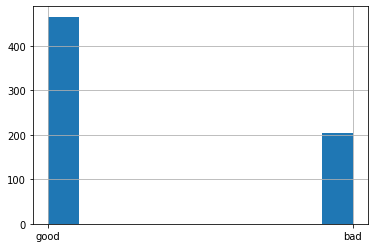

In [4]:
train_y.hist()

## 3.3 Data Cleaning

Given that the dataset has both numerical and categorical columns with missing values, we "project" the data based on types using the Lale operator `Project` and use:

- One-hot encoding for categorical columns. 
  - We can specify partial hyperparameters like `handle_unknown` to specify our policy for handling unseen categories.
- Simple imputation for numerical columns

After the appropriate data type specific operations, we append the columns back together with the `&` combinator and the `ConcatFeatures` operator.

In [5]:
from lale.lib.lale import Project, ConcatFeatures
from lale.lib.sklearn import OneHotEncoder, SimpleImputer
cat_enc = Project(columns={"type": "string"}) >> OneHotEncoder(handle_unknown="ignore")
num_prep = Project(columns={"type": "number"}) >> SimpleImputer()
prefix = (cat_enc & num_prep) >> ConcatFeatures()

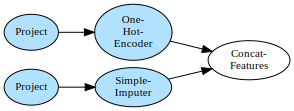

In [6]:
prefix.visualize()

## 3.4 Custom Data-prep

In this subsection, we will create a custom data-preparation pipeline which highlights:

- the use of the `|` (choice) combinator,
- the ability to use the predictions of one model as features for the final model, and
- the ability to specify a custom hyperparameter search space.

First, let us import some `sklearn` operators from `lale.lib.sklearn`.

In [7]:
import warnings
warnings.filterwarnings("ignore")
from lale.lib.lale import NoOp
from lale.lib.sklearn import KNeighborsClassifier
from lale.lib.sklearn import LogisticRegression, SVC, MLPClassifier
from lale.lib.sklearn import Nystroem
from lale.lib.sklearn import PCA
from lale.lib.sklearn import StandardScaler

### 3.4.1 Choice between PCA and Kernel PCA

Here we will create a sub-pipeline where we use the `|` (choice) operator to select between standard PCA and kernel PCA. While using the `PCA` operator performs the principal component analysis in the input space, the `Nystroem` operator projects the points in the kernel space, and a `PCA` in that space corresponds to a kernel PCA. So we choose between passing the data directly into `PCA` or passing it through `Nystroem` before feeding it into `PCA`.

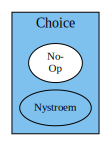

In [8]:
kernel_tfm_or_not =  NoOp | Nystroem
kernel_tfm_or_not.visualize()

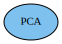

In [9]:
tfm = PCA
tfm.visualize()

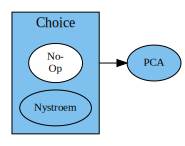

In [10]:
pca_or_kernel_pca = kernel_tfm_or_not >> tfm
pca_or_kernel_pca.visualize()

### 3.4.2 Custom Architectural Hyperparameters for MLP

Here we wish to customize the large search space of the `MLPClassifier` to only consider neural networks of at most depth 2 with a maximum of 50 neurons in each layer. We name this new custom operator `Shallow`.

In [11]:
MLPClassifier.hyperparam_schema('hidden_layer_sizes')

{'description': 'The ith element represents the number of neurons in the ith hidden layer.',
 'type': 'array',
 'laleType': 'tuple',
 'minItemsForOptimizer': 1,
 'maxItemsForOptimizer': 20,
 'items': {'type': 'integer',
  'minimumForOptimizer': 1,
  'maximumForOptimizer': 500},
 'default': [100]}

In [12]:
Shallow = MLPClassifier.customize_schema(
    hidden_layer_sizes={
        "type": "array",
        "laleType": "tuple",
        "minItemsForOptimzier": 1,
        "maxItemsForOptimizer": 2,
        "items": {"type": "integer", "minimumForOptimizer": 1, "maximumForOptimizer": 500},
        "default": [10]
    }
)

In [13]:
Shallow.hyperparam_schema('hidden_layer_sizes')

{'type': 'array',
 'laleType': 'tuple',
 'minItemsForOptimzier': 1,
 'maxItemsForOptimizer': 2,
 'items': {'type': 'integer',
  'minimumForOptimizer': 1,
  'maximumForOptimizer': 500},
 'default': [10]}

### 3.4.3 Custom Data-prep Pipeline

Using the sub-pipelines and operators we defined, we will create a data-prep pipelines where

- We preprocess the data via one-hot encoding of categorical and simple imputation for numerical columns.
- We apply standard scaling to all features.
- We generate features from PCA or kernel PCA via Nystroem sampling.
- We use the predictions from the `Shallow` neural network as additional new features.
  - Furthermore, we partially specify the `solver` hyperparameter of `Shallow` to be `adam`.

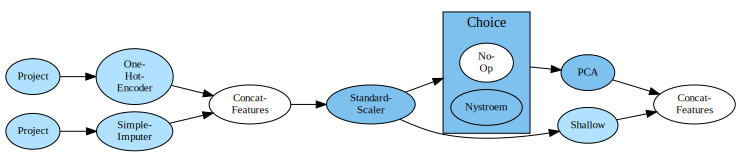

In [14]:
data_prep = (
    prefix >> StandardScaler >>
    (pca_or_kernel_pca & Shallow(solver='adam')) >> ConcatFeatures()
)
data_prep.visualize()                                         

## 3.5 Final Classifiers

In this subsection, we specify the search space for the final model that makes predictions based on the features generated by the above data-prep pipeline.

### 3.5.1 Custom Hyperparameters for $k$-neighbors Classifier

Here we consider the $k$-neighbors classifier and modify its hyperparameter search space to only consider a small number ($\leq 5$) of neighbors. We name this new operator `SmallK`.

In [15]:
KNeighborsClassifier.hyperparam_schema('n_neighbors')

{'description': 'Number of neighbors to use by default for kneighbors queries.',
 'type': 'integer',
 'distribution': 'uniform',
 'minimum': 1,
 'laleMaximum': 'X/maxItems',
 'default': 5,
 'maximumForOptimizer': 100}

In [16]:
SmallK = KNeighborsClassifier.customize_schema(
    n_neighbors={
        "type": "integer",
        "minimum": 1,
        "maximum": 5,
        "default": 3,
    }
)
SmallK.hyperparam_schema('n_neighbors')

{'type': 'integer', 'minimum': 1, 'maximum': 5, 'default': 3}

### 3.5.2 Final Estimators

The final model search space is a choice between a 
- `LogisticRegression` with partially specified hyperparameters `penalty='l1'` and `solver='liblinear'`, or
- `SmallK`, a $k$-neighbor classifier with a small $k$.

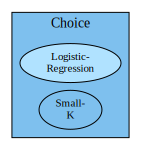

In [17]:
est = LogisticRegression(penalty='l1', solver='liblinear') | SmallK
est.visualize()

## 3.6 AutoML with Custom Pipeline

Here we put everything together and apply AutoML on this custom pipeline search space.
Let us visualize the complete pipeline search space.

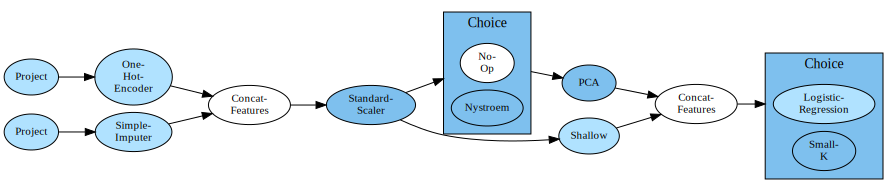

In [18]:
optimizable = data_prep >> est
optimizable.visualize()

### 3.6.1 CASH via `auto_configure`

We will invoke the `.auto_configure` method of a Lale pipeline to solve the CASH (Combined Algorithm Selection and Hyperparameter optimization) problem. In this example, we will use the [Hyperopt](http://hyperopt.github.io/hyperopt/) solver, but Lale also has other solvers such as [SMAC](https://automl.github.io/SMAC3/main/) and [HalvingGridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.HalvingGridSearchCV.html). See all available optimizers [here](https://lale.readthedocs.io/en/latest/modules/lale.lib.lale.html#module-lale.lib.lale).

Additional solver options can be passed to `auto_configure` via keyword arguments.

In [19]:
from lale.lib.lale import Hyperopt

In [20]:
best_pipeline = optimizable.auto_configure(
    train_X, train_y,
    Hyperopt,
    max_evals=15,
    max_eval_time=30,
    verbose=False,
)

100%|████████| 15/15 [02:52<00:00, 11.51s/trial, best loss: -0.7492537313432835]
4 out of 15 trials failed, call summary() for details.
Run with verbose=True to see per-trial exceptions.


Let us visualize the precise pipeline found by AutoML.

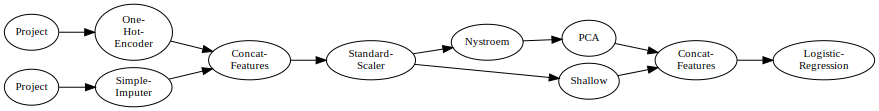

In [21]:
best_pipeline.visualize()

## 3.7 Pipeline Refinement

Once we have found a pipeline via AutoML, we might want to manually refine parts of it. Lale provides various capabilities to perform such refinements:

- `.remove_last()`: This removes final estimator in the pipeline and returns the prefix of the pipeline.
- `.freeze_trained()`: This returns a pre-trained pipeline whose model parameters and hyperparameters are frozen and this pipeline will not be retrained and the hyperparameters will not be tuned with `.auto_configure`.
- `.freeze_trainable()`: This returns a pipeline whose hyperparameters have been frozen and will not be re-optimized with `.auto_configure`. However, the model parameters in this part of the pipeline will be re-trained with the training data.

In this subsection, we will use these capabilities to change the final classifier in the above pipeline to a `SGDClassifier` and perform hyperparameter optimization for this `SGDClassifier` without requiring to re-train or re-tune the data-prep pipeline.

In [22]:
pre_trained_prefix = best_pipeline.freeze_trained().remove_last()

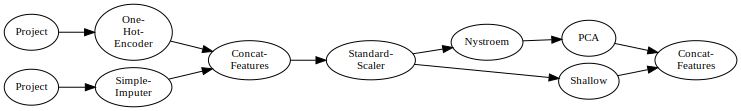

In [23]:
pre_trained_prefix.visualize()

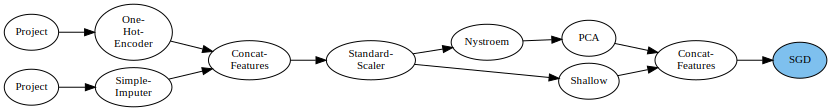

In [24]:
from lale.lib.sklearn import SGDClassifier as SGD
p1 = pre_trained_prefix >> SGD
p1.visualize()

100%|███████████| 5/5 [00:24<00:00,  4.93s/trial, best loss: -0.744776119402985]


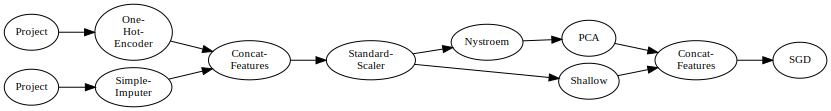

CPU times: user 1min 6s, sys: 2min 19s, total: 3min 26s
Wall time: 27.4 s


In [25]:
%%time
refined_pipeline = p1.auto_configure(train_X, train_y, Hyperopt, max_evals=5)
refined_pipeline.visualize()